# Inspect and measure the outputs from the latest version that includes:
1. Separate models for each of the sub-ontologies
2. Downloading models from huggingface instead of using checkpoints
3. Use the AmiGO dataset instead of CAFA5

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
from types import SimpleNamespace
from importlib import reload
import random

from argparse import ArgumentParser
from functools import partial
from tqdm import tqdm

import torch

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.backends.mps import is_available as mps_is_available
from torch.cuda import is_available as cuda_is_available, is_bf16_supported
from torch.amp import autocast
from torch.nn.utils import clip_grad_norm_

from torchmetrics.classification import BinaryPrecision, BinaryRecall, PrecisionRecallCurve

from transformers import EsmTokenizer, EsmConfig, EsmForSequenceClassification

from data import AmiGO
import go_wrapper
from metrics import ExcessGraphComponents, PrecisionRecallCurve, SimplePrecision, SimpleRecall

AVAILABLE_BASE_MODELS = {
    'cc': ['andrewdalpino/ESM2-35M-Protein-Cellular-Component',],
    'mf': ['andrewdalpino/ESM2-35M-Protein-Molecular-Function',],
    'bp': ['andrewdalpino/ESM2-35M-Protein-Biological-Process',],
}

args = SimpleNamespace()
# args.checkpoint_path = "./checkpoints/checkpoint.pt"
args.dataset_subset = 'cc'


args.device = "mps"
args.seed = None
# args.base_model = "facebook/esm2_t12_35M_UR50D"
# args.base_model = "facebook/esm2_t6_8M_UR50D"
args.base_model = 'andrewdalpino/ESM2-35M-Protein-Cellular-Component'
args.context_length = 1026
args.filter_long_sequences = True
args.batch_size = 16
args.num_dataset_processes = 1
args.max_grad_norm = 1.0
args.max_batches = 10

assert args.base_model in AVAILABLE_BASE_MODELS[args.dataset_subset], f"Base model {args.base_model} is not in the available models. Valid models are: {AVAILABLE_BASE_MODELS[args.dataset_subset]}"

In [5]:
if args.device == 'cuda' and is_bf16_supported():
    dtype = torch.bfloat16
    # amp_context = autocast(device_type=args.device, dtype=dtype)

elif args.device == 'mps':
    dtype = torch.float32
else:
    dtype = torch.float32
    # amp_context = autocast(device_type=args.device, dtype=dtype)
    torch.set_float32_matmul_precision("high")

amp_context = autocast(device_type=args.device, dtype=dtype)

if args.seed is not None:
    torch.manual_seed(args.seed)
    random.seed(args.seed)

tokenizer = EsmTokenizer.from_pretrained(args.base_model)

new_dataset = partial(
    AmiGO,
    subset=args.dataset_subset,
    tokenizer=tokenizer,
    context_length=args.context_length,
    filter_long_sequences=args.filter_long_sequences,
)

training = new_dataset(split="train")
testing = new_dataset(split="test")

new_dataloader = partial(
    DataLoader,
    batch_size=args.batch_size,
    pin_memory=all(device not in args.device for device in ("cpu", "mps")),
    num_workers=args.num_dataset_processes,
)

train_loader = new_dataloader(training, shuffle=True)
test_loader = new_dataloader(testing)


/Users/dylanskola/micromamba/envs/esm-function-classifier/lib/python3.13/site-packages/torch/amp/autocast_mode.py:339: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 and torch.float16 currently.
  warnings.warn(error_message)


In [ ]:
config = EsmConfig.from_pretrained(args.base_model)

config.problem_type = "multi_label_classification"
config.label2id = training.terms_to_label_indices
config.id2label = training.label_indices_to_terms
config.num_labels = training.num_classes

model = EsmForSequenceClassification.from_pretrained(args.base_model, config=config)


if args.device == "cuda":
    model = torch.compile(model)
    print("Model compiled")

model = model.to(args.device)


Some weights of the model checkpoint at andrewdalpino/ESM2-35M-Protein-Cellular-Component were not used when initializing EsmForSequenceClassification: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


../cafa-5-protein-function-prediction/Train/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms


In [61]:
reload(go_wrapper)
reload(metrics)

go_graph = go_wrapper.GOGraph('../cafa-5-protein-function-prediction/Train/go-basic.obo', root_ids = [go_wrapper.CC_ROOT_ID])

precision_metric = BinaryPrecision().to(args.device)
recall_metric = BinaryRecall().to(args.device)
pr_curve = PrecisionRecallCurve(num_thresholds=100).to(args.device)
if go_graph is not None:
    excess_graph_components = ExcessGraphComponents(go_graph).to(args.device)
else:
    excess_graph_components = None

  

../cafa-5-protein-function-prediction/Train/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms


In [7]:
args.max_batches = 10

In [51]:
epoch = 0
total_cross_entropy = 0.0
total_batches = 0
args.prob_threshold = 0.5

model.eval()

all_probs = []

with torch.no_grad():
    for batch_num, (x, y, attn_mask) in enumerate(
        tqdm(test_loader, desc=f"Test data epoch {epoch}", leave=False), start=1
    ):
        if batch_num > args.max_batches:
            break
        x = x.to(args.device, non_blocking=True)
        y = y.to(args.device, non_blocking=True)

        attn_mask = attn_mask.to(args.device, non_blocking=True)

        with amp_context:
            out = model.forward(x, attention_mask=attn_mask, labels=y)

        total_cross_entropy += out.loss.item()
        total_batches += 1

        predicted_probs = torch.sigmoid(out.logits)
        pr_curve.update(predicted_probs, y)
        all_probs.append(predicted_probs.cpu().numpy())

        if args.device == "mps":
            torch.mps.empty_cache()   # for MPS
        elif args.device == "cuda":
            torch.cuda.empty_cache()

        # break

precision, recall, thresholds = pr_curve.compute()
optimal_threshold, f1_max =pr_curve.get_optimal_threshold(beta=1.0)

all_predictions = metrics.apply_prob_threshold(np.concatenate(all_probs), optimal_threshold).cpu().numpy()
all_predicted_go_terms = metrics.get_predicted_go_terms(all_predictions, testing.label_indices_to_terms)

if excess_graph_components is not None:
    # Compute the excess number of disconnected graph components
    excess_graph_components.update(all_predicted_go_terms)
    excess_components_mean = excess_graph_components.compute()

average_cross_entropy = total_cross_entropy / total_batches



AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [23]:
print(f"F-max: {f1_max}")
print(f"Average excess components per term: {excess_components_mean}")
print(f"optimal threshold: {optimal_threshold}")

F-max: 0.6766098737716675
Average excess components per term: 0.001889438135549426
optimal threshold: 0.49494948983192444


# Examine the last batch

In [24]:
reload(metrics)

<module 'metrics' from '/Users/dylanskola/workspace/esm2-function-classifier/metrics.py'>

In [63]:
reload(go_wrapper)
reload(metrics)

go_graph = go_wrapper.GOGraph('../cafa-5-protein-function-prediction/Train/go-basic.obo', root_ids = [go_wrapper.CC_ROOT_ID])


../cafa-5-protein-function-prediction/Train/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms


In [98]:
threshold = 0.5

predictions = metrics.apply_prob_threshold(predicted_probs, threshold).cpu().numpy()
predicted_go_terms = metrics.get_predicted_go_terms(predictions, testing.label_indices_to_terms)
true_go_terms = metrics.get_predicted_go_terms(metrics.apply_prob_threshold(y, threshold).cpu().numpy(), testing.label_indices_to_terms)

True terms:  ['organelle', 'membrane', 'cellular anatomical entity', 'cellular_component', 'membrane-bounded organelle', 'intracellular anatomical structure']
False positive terms:  ['GTPase complex', 'heterotrimeric G-protein complex', 'extrinsic component of plasma membrane', 'plasma membrane', 'protein-containing complex', 'cytoplasmic side of membrane', 'extrinsic component of cytoplasmic side of plasma membrane', 'extrinsic component of membrane', 'cytoplasmic side of plasma membrane', 'membrane protein complex']
False negative terms:  ['thylakoid', 'cytoplasm', 'outer membrane', 'intracellular non-membrane-bounded organelle', 'organelle outer membrane', 'endoplasmic reticulum', 'endomembrane system', 'chloroplast thylakoid membrane', 'chloroplast', 'organelle membrane', 'chloroplast thylakoid', 'cytosol', 'plastid thylakoid', 'plastid thylakoid membrane', 'organelle envelope', 'intracellular organelle', 'plastid envelope', 'intracellular membrane-bounded organelle', 'plastid', 't

(<Figure size 2400x2400 with 1 Axes>, <Axes: >)

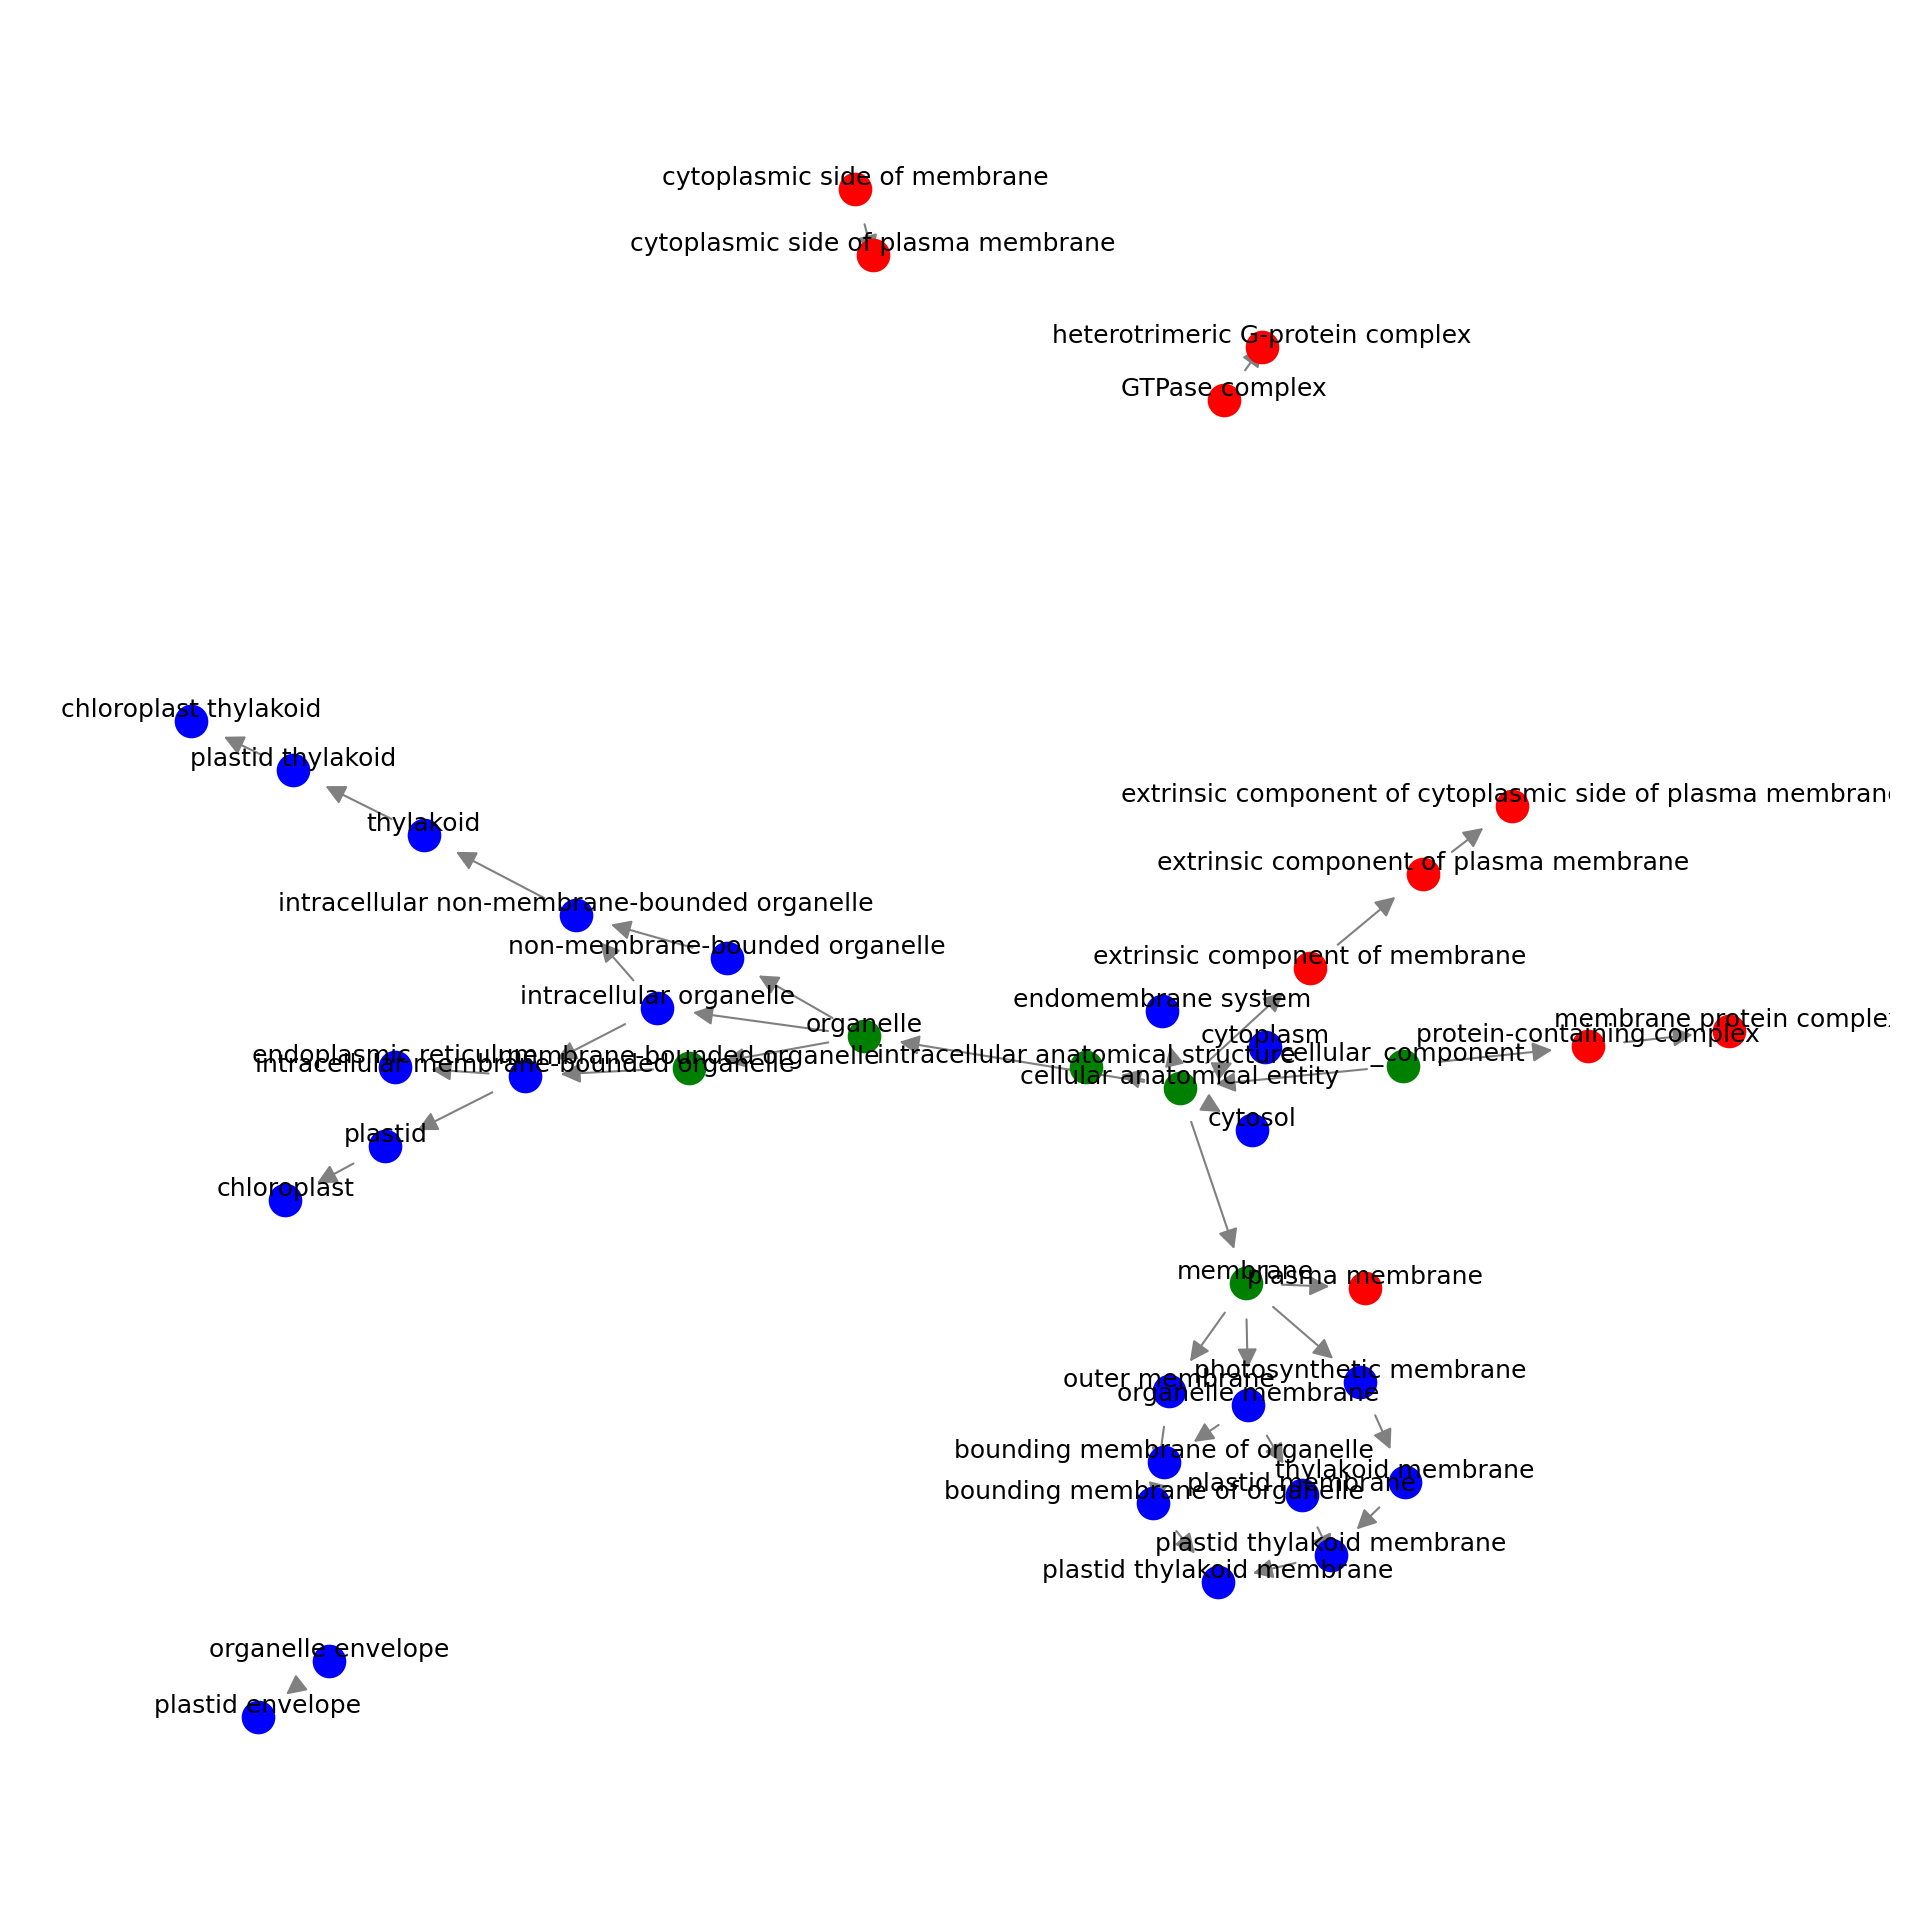

In [99]:
sample_idx = 0

this_true_terms = true_go_terms[sample_idx]
this_predicted_terms = predicted_go_terms[sample_idx]

result = describe_go_term_predictions(this_true_terms, this_predicted_terms, go_graph, convert_to_names=True)
print('True terms: ', result['tp_terms'])
print('False positive terms: ', result['fp_terms'])
print('False negative terms: ', result['fn_terms'])

go_graph.plot_go_subgraphs_true_vs_predicted(this_true_terms, this_predicted_terms, label_by_name=True)

In [40]:
from typing import Container
from go_wrapper import GOGraph

def describe_go_term_predictions(true_terms: Container[str], predicted_terms: Container[str], go_graph: GOGraph, convert_to_names: bool = False) -> dict:
    tp_terms = set(true_terms) & set(predicted_terms)
    fp_terms = set(predicted_terms) - set(true_terms)
    fn_terms = set(true_terms) - set(predicted_terms)

    if convert_to_names:
        tp_terms = [go_graph.ids_to_terms[id] for id in tp_terms]
        fn_terms = [go_graph.ids_to_terms[id] for id in fn_terms]
        fp_terms = [go_graph.ids_to_terms[id] for id in fp_terms]

    return {
        'tp_terms': tp_terms,
        'fp_terms': fp_terms,
        'fn_terms': fn_terms
    }

{'tp_terms': ['organelle',
  'membrane',
  'cellular anatomical entity',
  'cellular_component',
  'membrane-bounded organelle',
  'intracellular anatomical structure',
  'bounding membrane of organelle'],
 'fp_terms': ['GTPase complex',
  'heterotrimeric G-protein complex',
  'extrinsic component of plasma membrane',
  'plasma membrane',
  'protein-containing complex',
  'cytoplasmic side of membrane',
  'extrinsic component of cytoplasmic side of plasma membrane',
  'extrinsic component of membrane',
  'cytoplasmic side of plasma membrane',
  'membrane protein complex'],
 'fn_terms': ['thylakoid',
  'cytoplasm',
  'outer membrane',
  'intracellular non-membrane-bounded organelle',
  'organelle outer membrane',
  'endoplasmic reticulum',
  'endomembrane system',
  'chloroplast thylakoid membrane',
  'chloroplast',
  'organelle membrane',
  'chloroplast thylakoid',
  'cytosol',
  'plastid thylakoid',
  'plastid thylakoid membrane',
  'organelle envelope',
  'intracellular organelle',
 

In [42]:
thresholds, precision, recall = pr_curve.compute()

thresholds.shape, precision.shape, recall.shape

(torch.Size([100]), torch.Size([100]), torch.Size([100]))

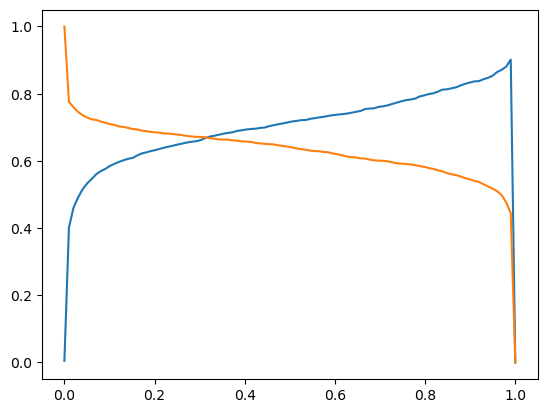

In [43]:
thresholds = thresholds.cpu().numpy()
precision = precision.cpu().numpy()
recall = recall.cpu().numpy()


plt.plot(thresholds, precision)
plt.plot(thresholds, recall)
plt.show()









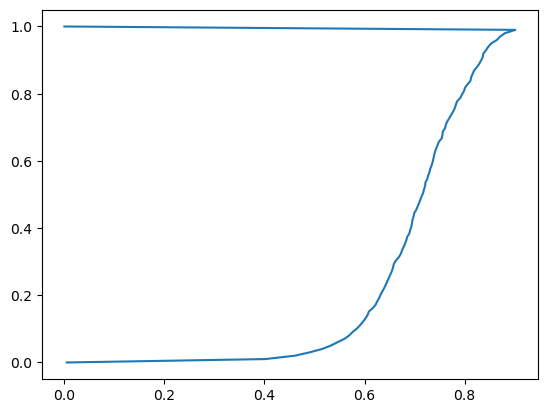

In [70]:
plt.plot(recall.cpu().numpy(), precision.cpu().numpy())

In [75]:
from datasets import load_dataset

DATASET_NAME = "andrewdalpino/AmiGO"
amigo = load_dataset(DATASET_NAME, name='cc', split='test')


In [78]:
amigo

Dataset({
    features: ['id', 'sequence', 'taxon_id', 'go_terms', 'stratum_id'],
    num_rows: 6671
})

In [79]:
amigo['id'][0]

'P9WGY5'

In [82]:
from goatools.obo_parser import GODag
godag = GODag('../cafa-5-protein-function-prediction/Train/go-basic.obo')

../cafa-5-protein-function-prediction/Train/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms


In [86]:
dir(godag)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_populate_relationships',
 '_populate_terms',
 '_set_level_depth',
 '_str_desc',
 'clear',
 'copy',
 'data_version',
 'draw_lineage',
 'fromkeys',
 'get',
 'id2int',
 'items',
 'keys',
 'label_wrap',
 'load_obo_file',
 'make_graph_pydot',
 'make_graph_pygraphviz',
 'paths_to_top',
 'pop',
 'popitem',
 'query_term',
 'setdefault',
 'typedefs',
 'update',
 'update_association',
 'values',
 'version',

In [87]:

import requests, json
from os import path
from Bio import SeqIO
from time import sleep

# Get this file from https://www.uniprot.org/help/downloads.
fasta_path = "./dataset/uniprot_sprot.fasta"

start_offset = 1

dataset_path = "./dataset/dataset.jsonl"

params = {
    "fields": [
        " protein_existence",
        " go_p",
        " go_c",
        " go_f",
    ],
}

headers = {
    "accept": "application/json"
}

base_url = "https://rest.uniprot.org/uniprotkb"

with open(dataset_path, "a") as dataset_file, open(fasta_path, "r") as fasta_file:
    for index, record in enumerate(SeqIO.parse(fasta_file, "fasta"), start=1):
        if index < start_offset:
            continue

        sequence_id = record.id.split("|")[1]
        taxon_id = record.description.split("OX=", 1)[1].split(" ")[0]
        sequence = str(record.seq)

        url = path.join(base_url, sequence_id)

        response = requests.get(url, headers=headers, params=params)

        while response.status_code == 503:
            retry_after = int(response.headers.get("Retry-After", 5))

            print(f"Rate limit exceeded. Retrying in {retry_after} seconds ...")

            sleep(retry_after)

            response = requests.get(url, headers=headers, params=params)

        
        if response.status_code != 200:
            print(f"Error fetching data for {sequence_id}: {response.status_code}")

            continue

        data = response.json()

        existence_code = data["proteinExistence"].split(":", 1)[0]

        go_terms = []

        if "uniProtKBCrossReferences" not in data:
            continue

        for cross_reference in data["uniProtKBCrossReferences"]:
            if "database" not in cross_reference:
                continue

            if cross_reference["database"] == "GO":
                id = cross_reference["id"]

                aspect = "?"
                evidence_code = "?"

                for property in cross_reference["properties"]:
                    if property["key"] == "GoTerm":
                        aspect_code = property["value"].split(":", 1)[0]

                        match aspect_code:
                            case "F":
                                aspect = "mf"
                            case "P":
                                aspect = "bp"
                            case "C":
                                aspect = "cc"

                    if property["key"] == "GoEvidenceType":
                        evidence_code = property["value"].split(":", 1)[0]

                go_term = {
                    "id": id,
                    "aspect": aspect,
                    "evidence_code": evidence_code,
                }

                go_terms.append(go_term)

        if len(go_terms) == 0:
            continue

        line = json.dumps({
            "id": sequence_id,
            "sequence": sequence,
            "go_terms": go_terms,
            "taxon_id": str(taxon_id),
            "existence_code": existence_code,
        }) + "\n"

        dataset_file.write(line)

        print(
            f"Record: #{index:,}, ID: {sequence_id}, "
            f"Length: {len(sequence)}, GO Terms: {len(go_terms):,}"
        )

print("Done!")


SyntaxError: unterminated string literal (detected at line 1) (4081829841.py, line 1)

In [102]:
[str(term) for term in this_predicted_terms]

['GO:0005575',
 'GO:0005622',
 'GO:0005834',
 'GO:0005886',
 'GO:0009898',
 'GO:0016020',
 'GO:0019897',
 'GO:0019898',
 'GO:0031234',
 'GO:0032991',
 'GO:0043226',
 'GO:0043227',
 'GO:0098562',
 'GO:0098796',
 'GO:0110165',
 'GO:1905360']

In [91]:
x = ['GO:0005575',
 'GO:0005576',
 'GO:0005615',
 'GO:0005622',
 'GO:0005737',
 'GO:0005765',
 'GO:0005774',
 'GO:0005834',
 'GO:0005886',
 'GO:0009898',
 'GO:0016020',
 'GO:0019897',
 'GO:0019898',
 'GO:0031090',
 'GO:0031234',
 'GO:0031982',
 'GO:0032991',
 'GO:0036477',
 'GO:0042995',
 'GO:0043226',
 'GO:0043227',
 'GO:0043230',
 'GO:0043231',
 'GO:0044297',
 'GO:0065010',
 'GO:0070062',
 'GO:0071944',
 'GO:0098552',
 'GO:0098562',
 'GO:0098588',
 'GO:0098796',
 'GO:0098797',
 'GO:0098852',
 'GO:0110165',
 'GO:0120025',
 'GO:1902494',
 'GO:1903561',
 'GO:1905360']

In [92]:
x

['GO:0005575',
 'GO:0005576',
 'GO:0005615',
 'GO:0005622',
 'GO:0005737',
 'GO:0005765',
 'GO:0005774',
 'GO:0005834',
 'GO:0005886',
 'GO:0009898',
 'GO:0016020',
 'GO:0019897',
 'GO:0019898',
 'GO:0031090',
 'GO:0031234',
 'GO:0031982',
 'GO:0032991',
 'GO:0036477',
 'GO:0042995',
 'GO:0043226',
 'GO:0043227',
 'GO:0043230',
 'GO:0043231',
 'GO:0044297',
 'GO:0065010',
 'GO:0070062',
 'GO:0071944',
 'GO:0098552',
 'GO:0098562',
 'GO:0098588',
 'GO:0098796',
 'GO:0098797',
 'GO:0098852',
 'GO:0110165',
 'GO:0120025',
 'GO:1902494',
 'GO:1903561',
 'GO:1905360']

In [95]:
true_go_terms = [str(term) for term in true_go_terms[0]]
true_go_terms

['G', 'O', ':', '0', '0', '0', '5', '5', '7', '5']